In [1]:
import os
import numpy as np
import torch
import scipy
from radioNN.data.loader import AntennaDataset
from radioNN.data.transforms import sph2cart
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from radioNN.process_network import NetworkProcess
from radioNN.networks.antenna_fc_network import AntennaNetworkFC
from view_scalars import thin_or_not
from view_scalars import get_fluences0, get_fluences1, get_lateral_distance
from scipy import integrate
from tqdm.auto import tqdm
radio_data_path = "/home/denis/memmap_files/memmap"
input_data_file = os.path.join(radio_data_path, "input_data.npy")
input_meta_file = os.path.join(radio_data_path, "meta_data.npy")
antenna_pos_file = os.path.join(radio_data_path, "antenna_pos_data.npy")
output_meta_file = os.path.join(radio_data_path, "output_meta_data.npy")
#output_file = os.path.join(radio_data_path, "output_gece_data.npy")
output_file = os.path.join(radio_data_path, "output_vBvvB_data.npy")
dataset = AntennaDataset(
    input_data_file,
    input_meta_file,
    antenna_pos_file,
    output_meta_file,
    output_file,
    mmap_mode='r',
    one_shower=33,
    # return_fluence=False,
    # percentage=0.01,
)
process = NetworkProcess(
    model_class=AntennaNetworkFC,
    # one_shower=one_shower,
    percentage=100,
    batch_size=8,
    wb=False,
)
process.output_channels = 3
#process.model = torch.load(
    # "/home/pranav/MEGA/work-stuff/radio_nn/runs/2309Sep26Tue_155429/SavedModel",
    # "/home/pranav/MEGA/work-stuff/radio_nn/runs/2405May14Tue_172854/SavedModel",
   #"/home/pranav/MEGA/work-stuff/radio_nn/runs/2405May18Sat_030851/SavedModel",
 #   "/home/pranav/MEGA/work-stuff/radio_nn/runs/2405May24Fri_145354/SavedModel",
    #"/home/pranav/MEGA/work-stuff/radio_nn/runs/2406Jun10Mon_144306/SavedModel",
  #  map_location=torch.device("cpu"),
#)
#process.model.eval()

#model_name = "2405May24Fri_145354" #awesome model but only zenith 45-55
#model_name = "2406Jun10Mon_144306"
#model_name = "2406Jun20Thu_200714"
#model_name = "2407Jul29Mon_213725" #decent model
model_name = "2506Jun11Wed_024718" 
process.model = AntennaNetworkFC(3)
state_checkpoint = torch.load(
    f"/home/denis/radio_nn/runs/{model_name}/SavedState",
)
process.model.load_state_dict(state_checkpoint['model_state_dict'])
process.model.eval()
def make_table(input_meta):
    """
    Meta Data format:
    index 0: Sim number
    index 1: Cos(Zenith Angle)
    index 2: X_max
    index 3: density at X_max
    index 4: height at X_max
    index 5: E_em
    index 6: sin(geomagnetic_angle)
    index 7: B inclination
    index 8: B declination
    index 9: B strength
    index 10: primary particle
    index 11: primary energy
    index 12: Azimuthal angle
    """
    return {
        "Sim number": input_meta[0],
        "Zenith": np.rad2deg(np.arccos(input_meta[1])),
        "X_max": input_meta[2]*700,
        "density at X_max": input_meta[3],
        "height at X_max": input_meta[4]*700*1e3,
        "E_em": np.exp(input_meta[5]*20),
        "sin(geomagnetic_angle)": input_meta[6],
        "B inclination": input_meta[7],
        "B declination": input_meta[8],
        "B strength": input_meta[9],
        "primary particle": input_meta[10],
        "primary energy": np.exp(input_meta[11]),
        "Azimuth": np.rad2deg(input_meta[12]),
    }

/home/denis/miniconda3/envs/RadioNNLofar/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using the data from /home/denis/memmap_files/memmap in cpu with memmap mode: r using 100% of data
Total showers after filter 23927


100%|██████████| 23927/23927 [01:05<00:00, 364.20it/s] 


3
Using <class 'radioNN.networks.antenna_fc_network.AntennaNetworkFC'>


In [2]:
def make_event_str(input_meta):
    return '\n'.join((
    r'$\theta=%.2f$' % (np.rad2deg(np.arccos(input_meta[1])),),
    r'$X_{max}=%.2f$' % (input_meta[2]*700, ),
    r'$E_0=%.2e$' % (np.exp(input_meta[11]),)))

In [3]:
def box_hist(X, Y,bins = 8, xlabel='X', ylabel='Y'):
    import matplotlib.ticker as ticker
    # Use numpy.histogram for binning
    counts, bin_edges = np.histogram(X, bins=bins)

    # Calculate bin centers
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    width = (np.max(bin_edges) - np.min(bin_edges))/(bins*3)
    # Prepare a dictionary to store data for violin plots
    box_data = []
    for i, center in enumerate(bin_centers):
      # Filter data points within the current bin range
        bin_data = [y for x, y in zip(X, Y) if bin_edges[i] <= x < bin_edges[i+1]]
        box_data.append(bin_data)
    
    # Create the figure
    fig, ax = plt.subplots(figsize=(10,7))
    ax.boxplot(box_data, showfliers=False, positions=bin_centers, widths=width)  # Format bin center
    h = ax.hist2d(X,Y, bins=50, range=[[np.min(x_meta), np.max(x_meta)], [np.percentile(raderr,0.1), np.percentile(raderr,99.1)]], density=True, cmap='Reds')
    plt.colorbar(h[3], ax=ax, cmap='Reds')
    ax.xaxis.set_major_formatter('{x:0.1f}')
    # Overall plot customizations
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    plt.tight_layout()
    plt.show()

In [4]:
def bias_resolution(X, Y,bins = 8, xlabel='X', ylabel='Y'):
    import matplotlib.ticker as ticker
    # Use numpy.histogram for binning
    counts, bin_edges = np.histogram(X, bins=bins)

    # Calculate bin centers
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    # Prepare a dictionary to store data for violin plots
    box_data = []
    for i, center in enumerate(bin_centers):
      # Filter data points within the current bin range
        bin_data = [y for x, y in zip(X, Y) if bin_edges[i] <= x < bin_edges[i+1]]
        box_data.append(bin_data)
    
    # Create the figure
    fig, ax = plt.subplots(figsize=(10,7))
    mean_array = np.zeros((*bin_centers.shape,4))
    std_array = np.zeros((*bin_centers.shape,4))
    for i, dd in enumerate(box_data):
        dd = np.array(dd)
        a = (dd,)#[dd < np.percentile(dd,99)],)
        if len(a[0]) < 2:
            continue
        
        mean_boot = scipy.stats.bootstrap(a, np.mean, method='percentile')
        std_boot = scipy.stats.bootstrap(a, np.std, method='percentile')
        mean_array[i,0] = np.mean(a)
        mean_array[i,1] = mean_boot.confidence_interval.low
        mean_array[i,2] = mean_boot.confidence_interval.high
        mean_array[i,3] = mean_boot.standard_error
        std_array[i, 0] = np.std(a)
        std_array[i, 1] = std_boot.confidence_interval.low
        std_array[i, 2] = std_boot.confidence_interval.high
        std_array[i, 3] = std_boot.standard_error
    print(mean_array[:,0])
    print(mean_array[:,1:].T.shape)
    print(bin_centers.shape)
    ax.errorbar(bin_centers, mean_array[:,0], yerr=mean_array[:,3].T, label='bias', fmt='o', barsabove=True)
    ax.errorbar(bin_centers, std_array[:,0], yerr=std_array[:,3].T,label='resolution', fmt='o', barsabove=True)
    ax.xaxis.set_major_formatter('{x:2.0f}')
    # Overall plot customizations
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    plt.tight_layout()
    plt.legend()

In [5]:

def radiation_energy(real, pos, meta, sim, inp_meta):
    mask = np.abs(pos[:,0]<10) & (pos[:,1]>0)
    fluence = get_fluences0(real[mask], pos[mask], meta[mask]) + get_fluences1(real[mask], pos[mask], meta[mask])
    distance = get_lateral_distance(real[mask], pos[mask], meta[mask])
    sortind = np.argsort(distance)
    flu = fluence[sortind]
    d = distance[sortind]
    return integrate.trapezoid(flu*d,d)*2*np.pi

In [6]:

def footprint(real, pos, meta, sim, inp_meta, index=0):
    if index == 0:
        from view_scalars import get_fluences0 as sc_fn
    elif index == 1:
        from view_scalars import get_fluences1 as sc_fn
    elif index == 2:
        from view_scalars import thin_or_not as sc_fn
    else:
        from view_scalars import get_polarity as sc_fn
    from scipy.interpolate import RBFInterpolator
    fig, ax = plt.subplot_mosaic("ABCD", figsize=(20, 10), gridspec_kw={"width_ratios": [49, 1, 49, 1]})
    x_pos = pos[:, 0]
    y_pos = pos[:, 1]
    xs = np.linspace(np.nanmin(x_pos), np.nanmax(x_pos), 100)
    ys = np.linspace(np.nanmin(y_pos), np.nanmax(y_pos), 100)
    xx, yy = np.meshgrid(xs, ys)
    # points within a circle
    in_star = np.array(xx**2 + yy**2 <= np.nanmax(x_pos**2 + y_pos**2))
    scalar1 = sc_fn(real, pos, meta)
    scalar2 = sc_fn(sim, pos, meta)
    axeses = ["A", "B", "C", "D"]
    for axis_id in [0, 2]:
        axis = axeses[axis_id]
        if axis == "A":
            scalar = scalar1
            name = "CoREAS"
        else:
            scalar = scalar2
            name = "Neural Network"
        interp_func = RBFInterpolator(list(zip(x_pos, y_pos)), scalar, kernel="quintic")
        fp_interp = np.where(
            in_star.flatten(),
            interp_func(np.array([xx, yy]).reshape(2, -1).T),
            np.nan,
        ).reshape(100, 100)
        pcm = ax[axis].pcolormesh(
            xx,
            yy,
            fp_interp,
            vmin=np.min([np.min(scalar1), np.min(scalar2)]),
            vmax=np.max([np.max(scalar1), np.max(scalar2)]),
            cmap="inferno",
            shading="gouraud",
        )  # use shading="gouraud" to make it smoother

        # _cbi.set_label(self._skey, fontsize=20)
        ax[axis].set_ylabel("vvB / m")
        ax[axis].set_xlabel("vB / m")
        ax[axis].set_facecolor("white")
        ax[axis].set_aspect(1)
        ax[axis].set_xlim(-100, 100)
        ax[axis].set_ylim(-100,100)
        ax[axis].set_title(name)
        ax[axis].scatter(
            x_pos,
            y_pos,
            edgecolor="w",
            facecolor="none",
            s=5,
            lw=1.0,
        )
        _cbi = fig.colorbar(
                pcm, pad=0.5, cax=ax[axeses[axis_id + 1]], aspect=10, format=lambda x, _: f"{x:.1e}"
        )
    plt.show()

In [7]:
N = 2000
rad_energy = np.full((N,2), np.nan)
meta_list = np.full((N,13), np.nan)
for i, choice in tqdm(enumerate(np.random.choice(np.unique(np.arange(23927)), size=N)), total=N):
    data_ = dataset.data_of_single_shower(choice)
    inp_meta_, pos_, meta_, real_ = data_[1], data_[2], data_[3], data_[4]
    sph2cart(pos_)
    try:
        sim_ = process.pred_one_shower(choice)[1].numpy()
    except RuntimeError:
        tqdm.write(f"Skipping {choice}")
        pass
    #footprint(real_, pos_, meta_, sim_, data_[1])
    #footprint(sim_, pos_, meta_, sim_, data_[1])
    #footprint(real_, pos_, meta_, sim_, data_[1], index=1)
    #footprint(sim_, pos_, meta_, sim_, data[1], index=1)
    real_rad1d = radiation_energy(real_, pos_, meta_, sim_, inp_meta_)
    sim_rad1d = radiation_energy(sim_, pos_, meta_, sim_, inp_meta_)
    rad_energy[i,0]  = real_rad1d
    rad_energy[i,1] = sim_rad1d
    rel_rad_error = (real_rad1d - sim_rad1d)/real_rad1d
    if np.abs(rel_rad_error) > 5:
        tqdm.write(str(make_table(inp_meta_)))
        #footprint(real_, pos_, meta_, sim_, data_[1], index=0)
        #footprint(real_, pos_, meta_, sim_, data_[1], index=1)
    meta_list[i] = inp_meta_

  0%|          | 0/2000 [00:00<?, ?it/s]/home/denis/radio_nn/radioNN/data/transforms.py:53: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /home/builder/cbouss/pytorch/croot/pytorch_1685629640362/work/aten/src/ATen/native/TensorShape.cpp:3277.)
  meta_data.T[2] /= 700
  2%|▏         | 45/2000 [00:04<03:05, 10.54it/s]

Skipping 6563


 19%|█▉        | 383/2000 [00:37<02:28, 10.89it/s]

Skipping 7887


 22%|██▏       | 449/2000 [00:43<02:27, 10.52it/s]

Skipping 7772
{'Sim number': 0.0, 'Zenith': 35.68809, 'X_max': 559.8599851131439, 'density at X_max': 616.1717, 'height at X_max': 6389.899645000696, 'E_em': 7.012864945441031e+16, 'sin(geomagnetic_angle)': 0.8104695, 'B inclination': 1.1835027, 'B declination': 0.0, 'B strength': 0.49247536, 'primary particle': 5626.0, 'primary energy': 9.148703e+16, 'Azimuth': 138.99295}


 24%|██▍       | 479/2000 [00:46<02:19, 10.90it/s]

Skipping 20229
{'Sim number': 0.0, 'Zenith': 41.07279, 'X_max': 639.5300328731537, 'density at X_max': 681.7139, 'height at X_max': 5709.744803607464, 'E_em': 5.2630055627009496e+16, 'sin(geomagnetic_angle)': 0.3270318, 'B inclination': 1.1835027, 'B declination': 0.0, 'B strength': 0.49247536, 'primary particle': 5626.0, 'primary energy': 6.8157734e+16, 'Azimuth': 5.568197}


 32%|███▏      | 647/2000 [01:02<02:07, 10.60it/s]/home/denis/radio_nn/radioNN/data/transforms.py:51: RuntimeWarning: invalid value encountered in log
  event_data = module.log(event_data.T[4:] + 1e-14).T
 32%|███▏      | 649/2000 [01:02<02:05, 10.77it/s]

Skipping 22757


 34%|███▍      | 679/2000 [01:05<02:03, 10.69it/s]

Skipping 6690


 35%|███▌      | 707/2000 [01:07<01:57, 10.96it/s]

Skipping 14471
{'Sim number': 0.0, 'Zenith': 36.314976, 'X_max': 596.0499823093414, 'density at X_max': 636.928, 'height at X_max': 6224.564090371132, 'E_em': 8.861140393176504e+16, 'sin(geomagnetic_angle)': 0.32377276, 'B inclination': 1.1835027, 'B declination': 0.0, 'B strength': 0.49247536, 'primary particle': 5626.0, 'primary energy': 1.1410789e+17, 'Azimuth': -26.5755}


 41%|████      | 822/2000 [01:18<01:48, 10.85it/s]

Skipping 21347


 45%|████▌     | 908/2000 [01:26<01:40, 10.85it/s]

Skipping 22781
{'Sim number': 54.0, 'Zenith': 6.284814, 'X_max': 665.1199877262115, 'density at X_max': 893.2923, 'height at X_max': 3287.4352764338255, 'E_em': 6.177948791869792e+16, 'sin(geomagnetic_angle)': 0.46863815, 'B inclination': 1.1835027, 'B declination': 0.0, 'B strength': 0.49247536, 'primary particle': 5626.0, 'primary energy': 8.0111165e+16, 'Azimuth': -153.43239}


 46%|████▋     | 930/2000 [01:28<01:39, 10.73it/s]

Skipping 11915
{'Sim number': 0.0, 'Zenith': 48.18331, 'X_max': 680.2000224590302, 'density at X_max': 593.94275, 'height at X_max': 6832.462083548307, 'E_em': 1.3657037905747053e+17, 'sin(geomagnetic_angle)': 0.4964794, 'B inclination': 1.1835027, 'B declination': 0.0, 'B strength': 0.49247536, 'primary particle': 14.0, 'primary energy': 1.5611761e+17, 'Azimuth': 27.05344}


 52%|█████▏    | 1038/2000 [01:38<01:28, 10.83it/s]

Skipping 17077


 52%|█████▏    | 1048/2000 [01:38<01:22, 11.59it/s]

Skipping 17149


 53%|█████▎    | 1056/2000 [01:39<01:24, 11.21it/s]

Skipping 9918
{'Sim number': 0.0, 'Zenith': 9.973915, 'X_max': 792.3200368881226, 'density at X_max': 965.4839, 'height at X_max': 2381.1335675418377, 'E_em': 8.580676894848893e+16, 'sin(geomagnetic_angle)': 0.51133454, 'B inclination': 1.1835027, 'B declination': 0.0, 'B strength': 0.49247536, 'primary particle': 14.0, 'primary energy': 9.9679036e+16, 'Azimuth': -143.463}


 53%|█████▎    | 1066/2000 [01:40<01:24, 11.00it/s]

Skipping 8415
{'Sim number': 0.0, 'Zenith': 10.821018, 'X_max': 851.6899704933167, 'density at X_max': 1022.00775, 'height at X_max': 1993.016549386084, 'E_em': 8.807472980865158e+16, 'sin(geomagnetic_angle)': 0.4651463, 'B inclination': 1.1835027, 'B declination': 0.0, 'B strength': 0.49247536, 'primary particle': 14.0, 'primary energy': 1.0033101e+17, 'Azimuth': -109.9868}


 59%|█████▉    | 1176/2000 [01:50<01:13, 11.14it/s]

Skipping 20236


 61%|██████▏   | 1226/2000 [01:55<01:08, 11.37it/s]

Skipping 10687


 74%|███████▎  | 1474/2000 [02:17<00:44, 11.76it/s]

Skipping 9918


 80%|███████▉  | 1592/2000 [02:28<00:37, 10.98it/s]

Skipping 13188


 80%|████████  | 1608/2000 [02:30<00:43,  8.95it/s]

Skipping 22427
{'Sim number': 0.0, 'Zenith': 34.679146, 'X_max': 646.4999854564667, 'density at X_max': 735.8172, 'height at X_max': 5107.956985011697, 'E_em': 2.9847142653789286e+17, 'sin(geomagnetic_angle)': 0.64641017, 'B inclination': 1.1835027, 'B declination': 0.0, 'B strength': 0.49247536, 'primary particle': 5626.0, 'primary energy': 3.7377733e+17, 'Azimuth': -89.5876}


100%|██████████| 2000/2000 [03:06<00:00, 10.75it/s]


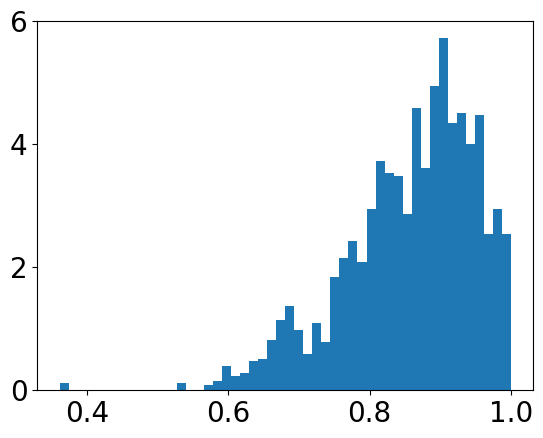

In [8]:
plt.hist(meta_list[:, 1], bins=50, density=True);

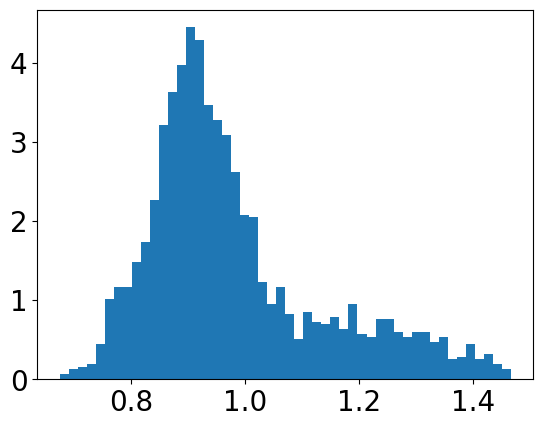

In [9]:
plt.hist(meta_list[:, 2],  bins=50, density=True);

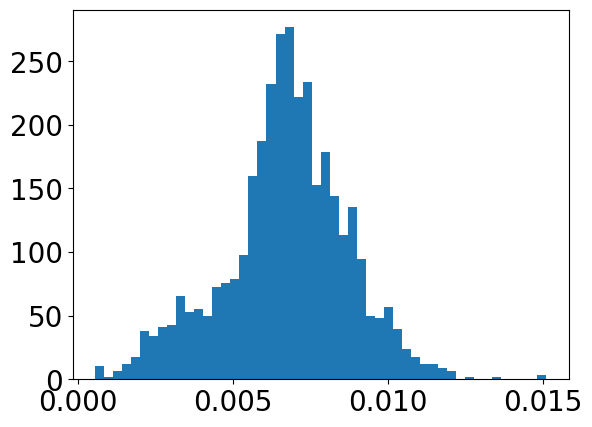

In [10]:
plt.hist(meta_list[:, 4],  bins=50, density=True);

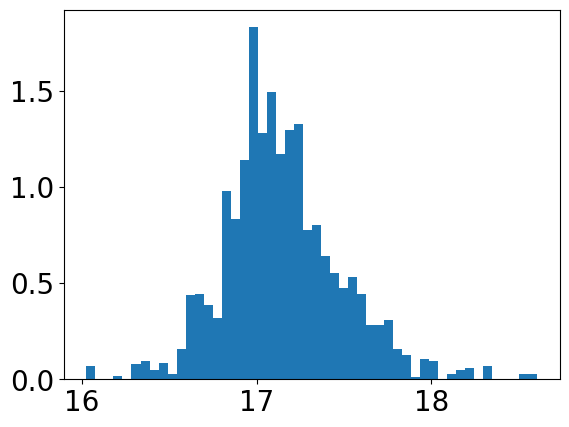

In [11]:
plt.hist(np.log10(np.exp(meta_list[:, 11])),  bins=50, density=True);

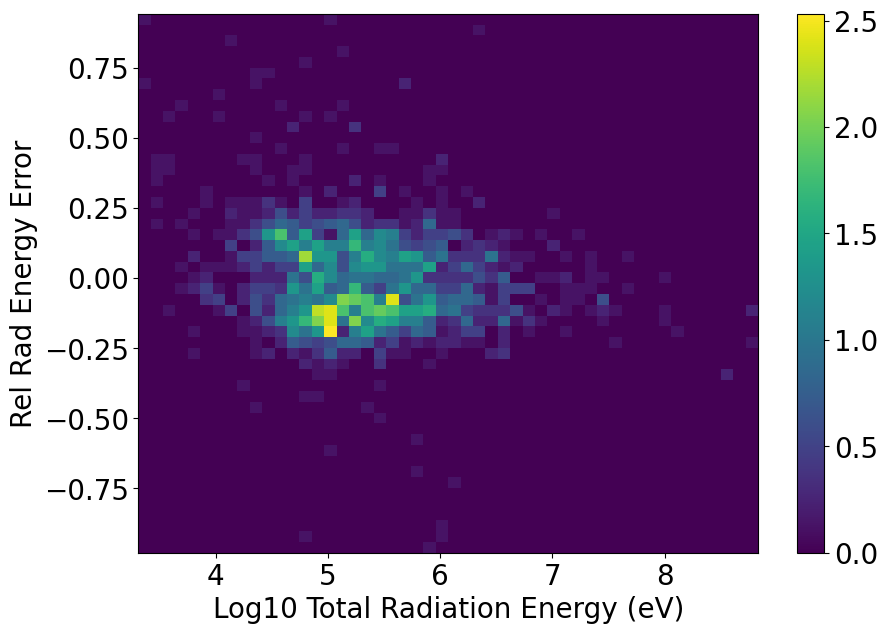

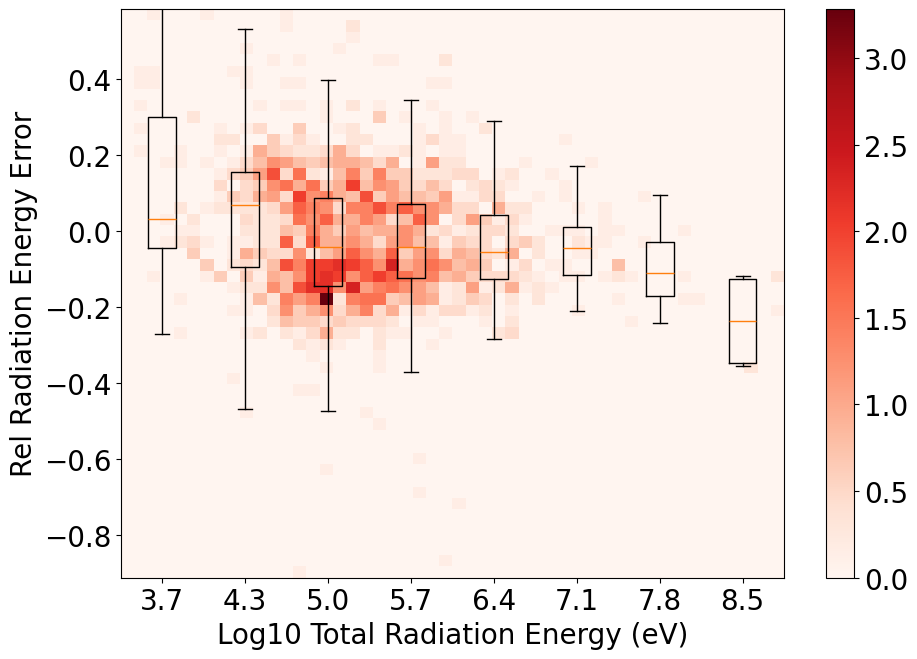

[ 0.14353512  0.05136392 -0.02239124 -0.02453475 -0.03917262 -0.03264396
 -0.08983149 -0.23550573]
(3, 8)
(8,)


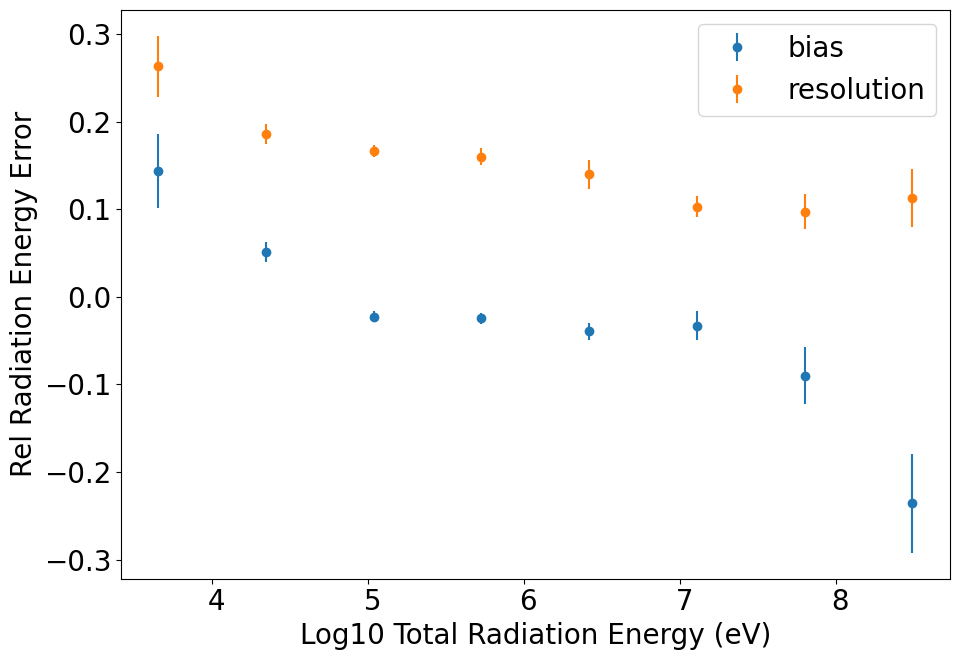

In [12]:
index = np.argwhere(np.isfinite(rad_energy[:,0]) & (rad_energy[:,0] > 0) & (meta_list[:, 2] < 1000/700)).flatten() 
x_meta = np.log10(rad_energy[index,0])
raderr = (rad_energy[index,1]-rad_energy[index,0])/rad_energy[index,0]
mask = (np.abs(raderr) < 1)
raderr = raderr[mask]
x_meta = x_meta[mask]
plt.figure(figsize=(10,7))
h=plt.hist2d(x_meta,raderr, bins=50, range=[[np.min(x_meta), np.max(x_meta)], [np.percentile(raderr,0), np.percentile(raderr,100)]], density=True)
plt.colorbar(h[3], ax=plt.gca())
plt.xlabel('Log10 Total Radiation Energy (eV)')
plt.ylabel('Rel Rad Energy Error')
box_hist(x_meta,raderr, xlabel='Log10 Total Radiation Energy (eV)', ylabel='Rel Radiation Energy Error')
bias_resolution(x_meta,raderr, xlabel='Log10 Total Radiation Energy (eV)', ylabel='Rel Radiation Energy Error')

In [13]:
i

1999

[-8.89683682  1.83060957 -0.71636421 -2.18427993 -3.3744905   0.60615303
 -1.98023123 -1.35756829 -0.80281877 -0.3225003  -1.8553195   0.81007535
 -1.2607806   6.45289362  0.          0.        ]
(3, 16)
(16,)


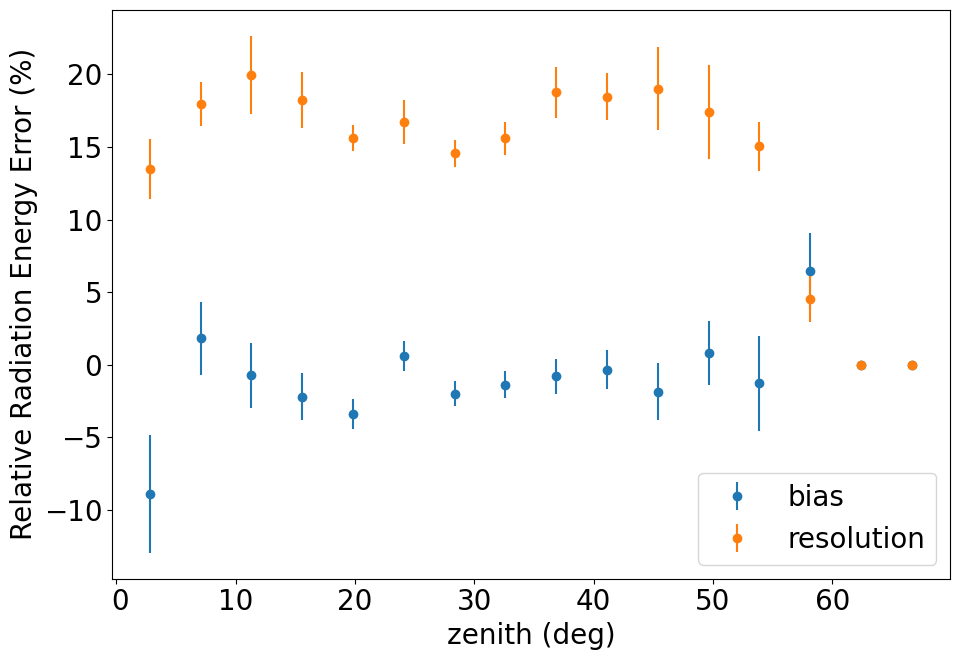

In [14]:
x_meta = np.rad2deg(np.arccos(meta_list[index, 1]))
raderr = (rad_energy[index,1]-rad_energy[index,0])/rad_energy[index,0]
mask = (np.abs(raderr) < 1)
raderr = raderr[mask]
x_meta = x_meta[mask]
#plt.figure(figsize=(10,7))
#h=plt.hist2d(x_meta,raderr, bins=50, range=[[np.min(x_meta), np.max(x_meta)], [np.percentile(raderr,0), np.percentile(raderr,100)]], density=True)
#plt.colorbar(h[3], ax=plt.gca())
#plt.xlabel('zenith')
#plt.ylabel('Rel Rad Energy Error')
#box_hist(x_meta,raderr, xlabel='zenith', ylabel='Rel Radiation Energy Error')
bias_resolution(x_meta,raderr*100, xlabel=r'zenith (deg)', ylabel='Relative Radiation Energy Error (%)', bins=16)
plt.savefig('rad_energy_zenith.pdf', format='pdf')

[12.73553499  1.82634727 -0.3573342  -6.32371092 -6.17131901 -2.72598481
 -2.03161968  7.02720367]
(3, 8)
(8,)


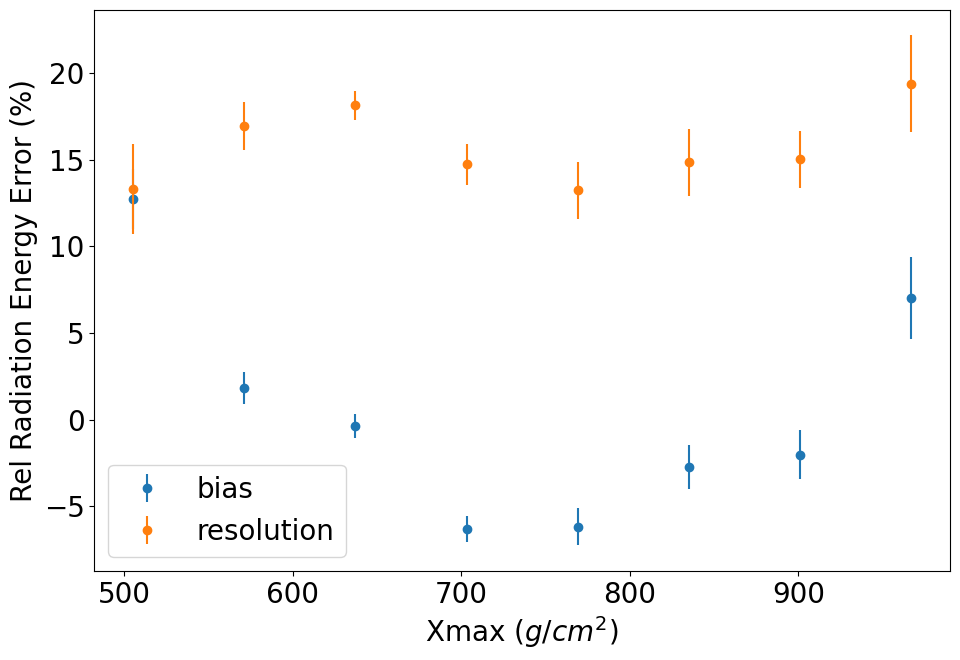

In [15]:
x_meta = meta_list[index, 2]*700
raderr = (rad_energy[index,1]-rad_energy[index,0])/rad_energy[index,0]
mask = (np.abs(raderr) < 1)
raderr = raderr[mask]
x_meta = x_meta[mask]

#plt.figure(figsize=(10,7))
#h = plt.hist2d(x_meta,raderr, bins=50, range=[[np.min(x_meta), np.max(x_meta)], [np.percentile(raderr,0), np.percentile(raderr,100)]], density=True)
#plt.colorbar(h[3], ax=plt.gca())
#plt.xlabel('Xmax')
#plt.ylabel('Rel Rad Energy Error')
#box_hist(x_meta,raderr, xlabel='Xmax', ylabel='Rel Radiation Energy Error')
bias_resolution(x_meta,raderr*100, xlabel=r'Xmax $(g/cm^2)$', ylabel='Rel Radiation Energy Error (%)')
plt.savefig('rad_energy_xmax.pdf', format='pdf')

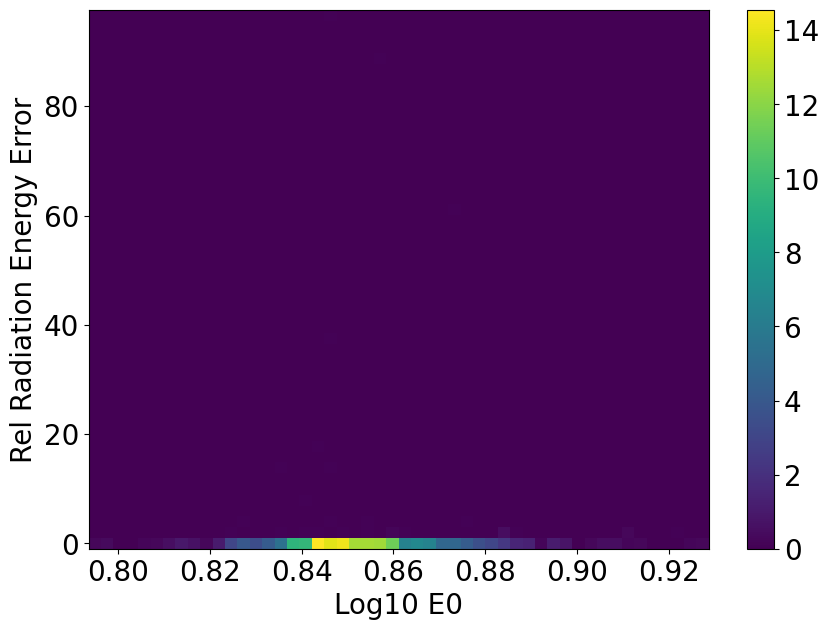

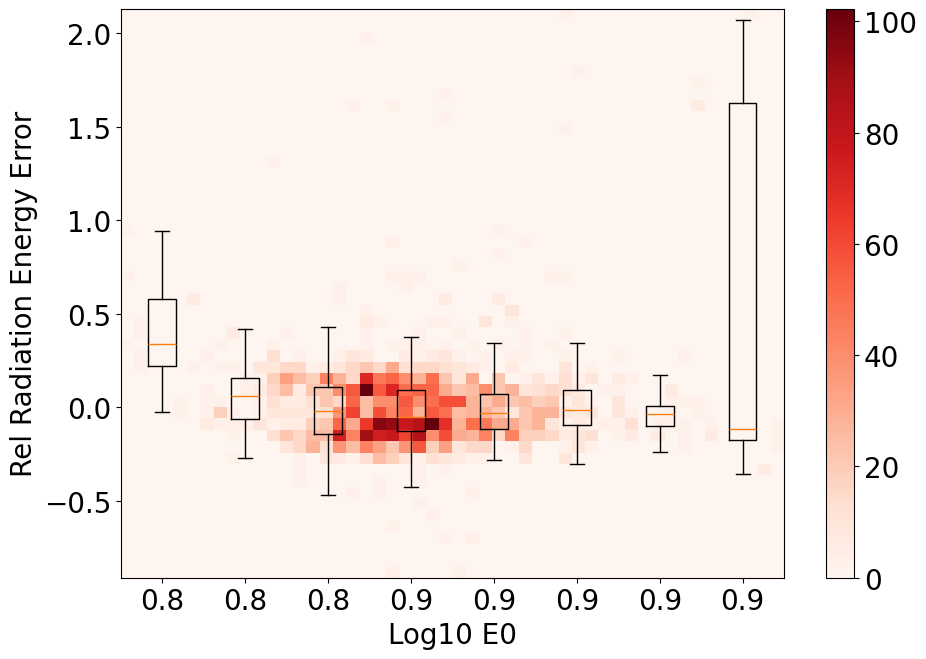

[ 0.38297809  0.10072291  0.07636549  0.26658463  0.17505027  0.10454247
 -0.02867636  0.5132898 ]
(3, 8)
(8,)


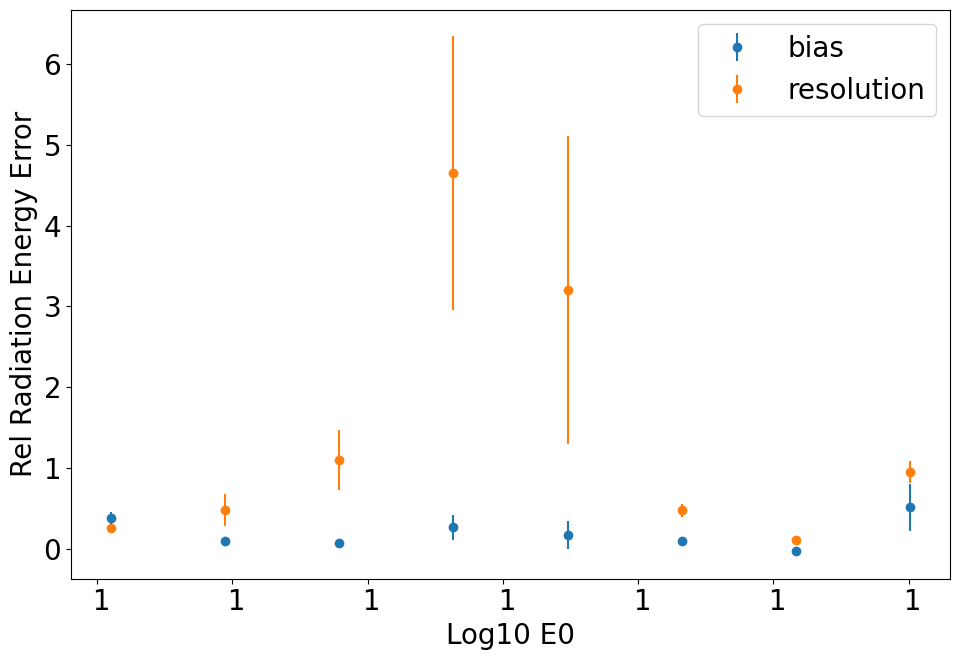

In [16]:
x_meta = np.log10(np.exp(meta_list[index, 5]))
raderr = (rad_energy[index,1]-rad_energy[index,0])/rad_energy[index,0]
plt.figure(figsize=(10,7))
h = plt.hist2d(x_meta,raderr, bins=50, range=[[np.min(x_meta), np.max(x_meta)], [np.percentile(raderr,0), np.percentile(raderr,100)]], density=True)
plt.colorbar(h[3], ax=plt.gca())
plt.ylabel('Rel Radiation Energy Error')
plt.xlabel('Log10 E0')
box_hist(x_meta,raderr, xlabel='Log10 E0', ylabel='Rel Radiation Energy Error')
bias_resolution(x_meta,raderr, xlabel='Log10 E0', ylabel='Rel Radiation Energy Error')

Text(0.5, 0, 'E_em')

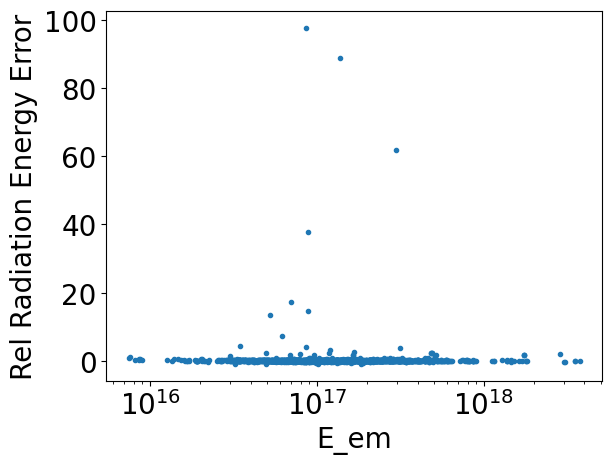

In [17]:
plt.scatter(np.exp(meta_list[index, 5]*20),(rad_energy[index,1]-rad_energy[index,0])/rad_energy[index,0], marker='.')
plt.xscale('log')
plt.ylabel('Rel Radiation Energy Error')
plt.xlabel('E_em')
